# Referenced 4 point ODMR Analysis

Author: Ryan Corbyn, 17th June 2021

This code makes use of many of the same methods as the CW ODMR dataset to analyse the datasets that are recorded with the microwave switch in place to allow for each ODMR frequency pixel point to be referenced to either a fixed ODMR frequnecy or to a empty channel with no microwaves applied. 

Using this ODMR curve as the reference, we will then copy in the 4 point ODMR data and plot the data relative to the full CW ODMR curve so that we can look at the difference between the 4 point ODMR and the CW curve to make sure that the datapoints look good. 

Note: This script is heavily based on that of the script "20210607_Reference_ODMR_script_plus_4points"

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
from scipy.signal import find_peaks

We start the code by loading in the dataset, the parameters file and the plot parameters.  

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [5]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

Normalise the ODMR data to the Reference data. Then find the mean of the normalised data. 

In [6]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2] + 1)
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 
    odmr_shape_3D = odmr_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [7]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

In [8]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

In [9]:
def stich_datasets(odmr_data, reference_data):
    '''This method is designed to stitch the ODMR and reference datasets 
    together when the switch has been bypassed in the microwave circuit setup.'''
    
    stitched_data = []
    for i in range(len(odmr_data[:,1])):
        stitched_data.append(odmr_data[i,:])
        stitched_data.append(reference_data[i,:])
    
    stitched_data = np.array(stitched_data)
    
    return(stitched_data)

Generates a scatter plot of the mean noramlised ODMR data. 

In [10]:
def scatter_plot(freq, mean_data, dwell_time):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Counts per ' + str(dwell_time) + r'$\mu$s', fontsize = 18)
    return(fig2, ax2)

In [11]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Find the initial parameters for the double lorentz fitting for the dataset, along with the code that is required for the lorentz fitting to be performed. 

In [12]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [13]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [14]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

Plot the fitting of the double lorentzian line shape and adds the labels and legends to the graphs. 

In [15]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

In [16]:
def get_fitting_contrast(res_freq1, res_freq2, freq, y_fit, baseline, step):
    
    step = str(step/1000) # step size in GHz and string
    decimals = step[::-1].find('.') # find the number of decimal points in the steps. 
    
    first_freq_min_index = (np.abs(freq-round(res_freq1, decimals))).argmin()
    second_freq_min_index =(np.abs(freq-round(res_freq2, decimals))).argmin()

    contrast = [(baseline - y_fit[first_freq_min_index])/baseline, (baseline - y_fit[second_freq_min_index])/baseline]
    
    return(contrast)

Find the R squared value for the fitting verses the actual dataset. 

In [17]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

The method to save the data into a folder on the iDrive. 

In [18]:
def save_data(date, file_ID, fitted_contrast, coeffs, opt_error, r_squared, fig1):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' #+ 'power_sweep\\'
    output_data_file = destination_folder + date + '_reference_ODMR_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency 2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' + 
                     'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID  + '\t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(fitted_contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(fitted_contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    #fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    #fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig1.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '.png', transparent = True) 

### Code starts here 

Here we set the folder directory and the file names of the datasets. We then load the dataset into the numpy arrays and generates the frequnecy array for the scans performed and the dwell time of the pixels used.

In [179]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20210707' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_09' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + '_ODMR1.dat'
file_name_ODMR2 = date + data_set + '_ODMR2.dat'
file_name_Ref1 = date + data_set  + '_Ref1.dat'
file_name_Ref2 = date + data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + '_Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
# Freq scan = frequency scan actually used in experiment, frreq = scan without triggering problems. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

## Script Note

This next part of the script will set whether the microwave switch was used for the experiments, which will determine what parts of the code are used. 

In [180]:
microwave_switch = 'on'
print(params_values)

odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

0        2.80
1        2.93
2        0.50
3    10000.00
4        1.00
5        0.00
6    10000.00
7        0.00
8      100.00
Name: Parameter value, dtype: float64
1 261 100


Here we normalise the ODMR data to the reference data and then find the mean of this normalised data. The code then works to determine the fitting of the double lorentzian to the ODMR data and find the R squared value for the fitting to the data. 

In [181]:

if microwave_switch == 'off':
    # Stitch the data together, 
    stitched_data = stich_datasets(odmr_data, reference_data)
    # Find the mean of the data. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_freq_points, mean_norm_odmr_full_disordered = mean_data(stitched_data)
    
    # Due to the Labview code triggering a scan to start at the 1st value, rather than the 0th value, 
    # we have that the final data point is supposed to be the first in the dataset. So I'll switch this round here. 
    mean_norm_odmr_full = np.roll(mean_norm_odmr_full_disordered, 1)
    
    
else: 
    # Normalise the ODMR data against the reference data. 
    normalised_ODMR = normalise_data(reference_data, odmr_data)

    # Mean of the normalise dataset. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_freq_points, mean_norm_odmr_full_disordered = mean_data(normalised_ODMR)
    mean_norm_odmr_full = np.roll(mean_norm_odmr_full_disordered, 1)


Contrast = [0.06586772884980678, 0.0679709516347637]
r squared = 0.9875587336310391


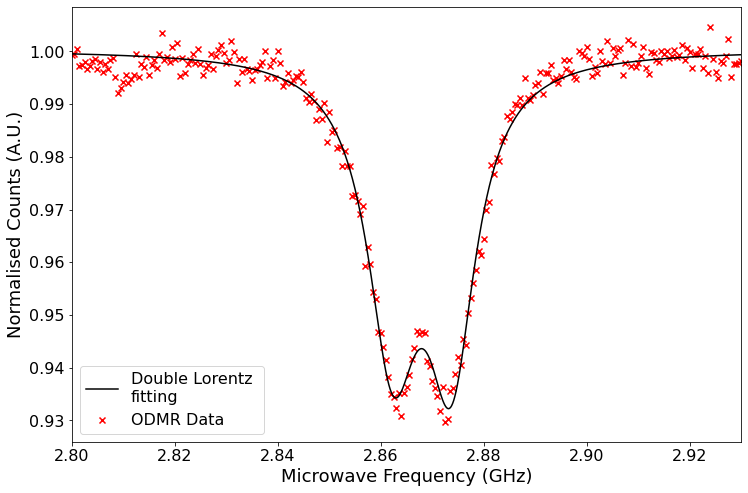

In [182]:

# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr_full)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr_full, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
#init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
init_params = [-0.8, 2.86, 0.005, dip_depth[1], 2.87, 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr_full, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax1
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])

fitted_contrast = get_fitting_contrast(fitting_params[1], fitting_params[4], freq, y_fit,  fitting_params[6], params_values[2])
print('Contrast = ' + str(fitted_contrast))

# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, mean_norm_odmr_full, y_fit)
print('r squared = ' + str(r_squared))

In [183]:
# Save the data. 

#save_data(date, file_name_ODMR1, fitted_contrast, coeffs, opt_error, r_squared, fig1)

In [184]:
print(odmr_data.shape)

(1, 261, 100)


# 4 Point ODMR data Analysis
Here we will copy in the 4 point ODMR data that is based on the CW ODMR curve seen in the previous section and plot the data points alongside the fitted double lorentz ODMR curve to see how closely the 4 point ODMR measures up to the CW curve. 

I will also calculate the point at which the negative and positive gradient straight lines from the dataset will intersect so that this can be used for temperature sensing. (And maybe B field sensing, but I'm really not sure of that just yet). 

In [185]:
def two_point_line(four_freq, four_intensities): 
    '''Just using simple maths to derive the gradient and y intercept from the 
    4 point to be used for fast ODMR.'''
    
    neg_grad = (four_intensities[0]-four_intensities[1])/(four_freq[0]-four_freq[1])
    neg_y_intercept = four_intensities[0] - neg_grad*four_freq[0]
    
    pos_grad = (four_intensities[2]-four_intensities[3])/(four_freq[2]-four_freq[3])
    pos_y_intercept = four_intensities[2] - pos_grad*four_freq[2]
    
    return(neg_grad, neg_y_intercept, pos_grad, pos_y_intercept)

In [186]:
def straight_line(x, m, c):
    '''Fit a straight lnie to the data provided'''
    y = m*x + c
    return(y)

In [277]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.

four_point_data_set = '_4_point_referenced_odmr_43' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
four_point_file_name_ODMR1 = date + four_point_data_set + '_ODMR1.dat'
four_point_file_name_ODMR2 = date + four_point_data_set + '_ODMR2.dat'
four_point_file_name_Ref1 = date + four_point_data_set  + '_Ref1.dat'
four_point_file_name_Ref2 = date + four_point_data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
four_point_odmr_data = load_data(folder_path + four_point_file_name_ODMR1)
four_point_reference_data = load_data(folder_path + four_point_file_name_Ref1)

# Get the parameters for the experiment. 
four_point_params_file = load_params(folder_path + date  + four_point_data_set + '_Params.txt')
four_point_params_values = four_point_params_file['Parameter value']
print(four_point_params_values)

0        2.800
1        2.803
2        1.000
3    10000.000
4        1.000
5        0.000
6    10000.000
7        0.000
8     1000.000
Name: Parameter value, dtype: float64


In [278]:
# Reshape the data so that it can be used for the following script. 
four_point_odmr_data, four_point_reference_data = reshape_data(four_point_reference_data, four_point_odmr_data, four_point_params_values)

# Need to have the four_freqs array layered as follows [F2, F3, F4, F1] due to riggering problems in the software.  
four_freqs = [2.8575 ,2.8595, 2.8765, 2.8785]

microwave_switch = 'on'

1 4 1000


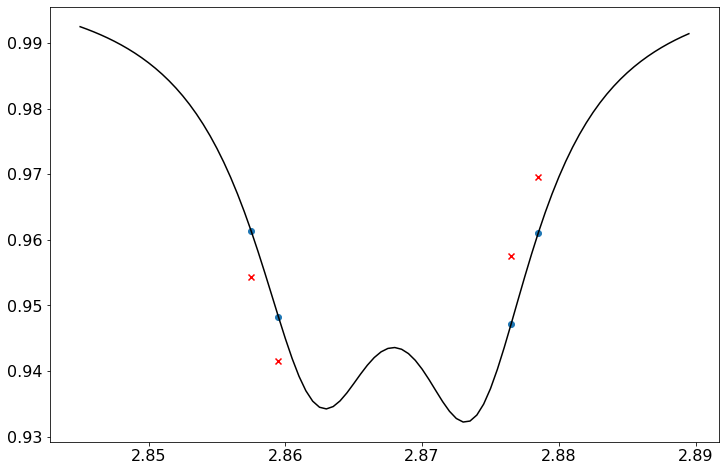

In [279]:
# Analyse the data. 

if microwave_switch == 'off':
    # Stitch the data together, 
    stitched_four_point_data = stich_datasets(four_point_odmr_data, four_point_reference_data)
    # Find the mean of the data. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_4_point_freq_points, mean_norm_4_point_odmr_full = mean_data(stitched_four_point_data)
else: 
    # Normalise the ODMR data against the reference data. 
    mean_norm_odmr_4_point = normalise_data(four_point_reference_data, four_point_odmr_data)

    # Mean of the normalise dataset. 
    # mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
    # mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
    mean_odmr_4_point_freq_points, mean_norm_4_point_odmr_full = mean_data(mean_norm_odmr_4_point)
    mean_norm_4_point_odmr_full = np.roll(mean_norm_4_point_odmr_full, 1)
    
# Plot the fitted double lorentz curve and mean normalised dataset as a scatter plot. 

#fig1, ax1 = normalised_scatter_plot(four_freqs, mean_norm_4_point_odmr_full)
plot.plot(freq[45*2:90*2], y_fit[45*2:90*2], color = 'k')
plot.scatter(four_freqs, mean_norm_4_point_odmr_full, color = 'r', marker = 'x')

indecies = []
indecies.append(np.where((np.round(freq, 4) == four_freqs[0]))[0])
indecies.append(np.where((np.round(freq, 4) == four_freqs[1]))[0])
indecies.append(np.where((np.round(freq, 4) == four_freqs[2]))[0])
indecies.append(np.where((np.round(freq, 4) == four_freqs[3]))[0])

indecies = np.array(indecies)

#plot.scatter(freq[50:85], y_fit[50:85])
plot.scatter(freq[indecies], y_fit[indecies], marker = 'o')


In [280]:
ind = np.abs(y_fit[0:150] - mean_norm_4_point_odmr_full[0]).argmin()
print(np.round(freq[ind],4))

2.8585


In [244]:
# Want to be able to plot multiple 4 point scans against one another so that we can see what sort of variation we are seeing between scans. 

intensities[f, :] = [mean_norm_4_point_odmr_full[0], mean_norm_4_point_odmr_full[1],
                    mean_norm_4_point_odmr_full[2], mean_norm_4_point_odmr_full[3]]
f = f + 1
print(intensities)


[[0.96303856 0.94953427 0.94732697 0.95969215]
 [0.96275238 0.95044626 0.9481838  0.96019653]
 [0.963146   0.94926845 0.94735488 0.95988867]
 [0.96257647 0.9503227  0.9485013  0.96083738]
 [0.96194118 0.95124544 0.94794791 0.95780903]
 [0.96236084 0.9492483  0.94650167 0.95985137]
 [0.96209009 0.95089715 0.94556511 0.96096374]
 [0.96226019 0.94972961 0.94852269 0.95999129]
 [0.96314724 0.95064383 0.94687707 0.95953852]
 [0.96288406 0.95085549 0.94725824 0.95959182]]


In [245]:
#intensities = np.zeros([10, 4]) 
#f = 0
mean_intensity = np.mean(intensities[0:3], axis = 0)
std_intenisty = np.std(intensities[0:3], axis = 0)

print(mean_intensity)
print(std_intenisty)

[0.96297898 0.94974966 0.94762188 0.95992578]
[0.00016613 0.00050438 0.0003975  0.00020758]


In [47]:
# Find the straight line gradients for the 2 points frequnecy points to be used for the 4 point ODMR scans
neg_gradient, neg_y_intercept, pos_gradient, pos_y_intercept = two_point_line(four_freqs, mean_norm_4_point_odmr_full)

neg_pos_intersection_freq = (pos_y_intercept - neg_y_intercept) / (neg_gradient - pos_gradient)
print(neg_pos_intersection_freq)

2.8616094852973637


[2.856, 2.858, 2.8725, 2.8745] [0.96304356 0.93231336 0.94926031 0.96255758]


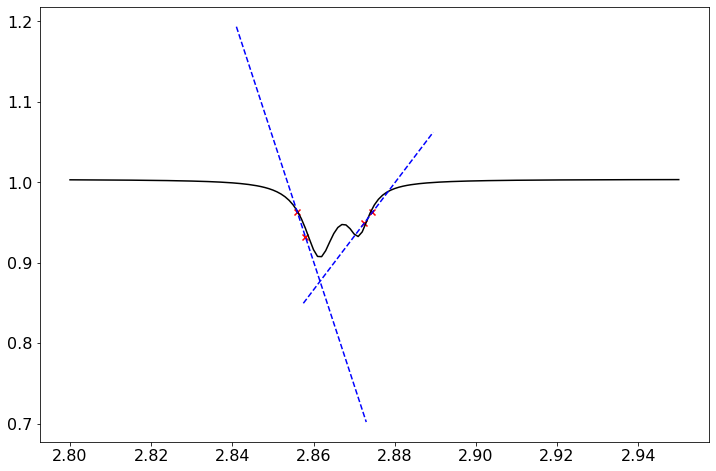

In [48]:
# Graphical representation of the stright line fits to collaborate that the 
# calculation of the intersection of the lines is accurate 

plot.plot(freq, y_fit, color = 'k')
plot.scatter(four_freqs, mean_norm_4_point_odmr_full, color = 'r', marker = 'x')

x1 = np.linspace(four_freqs[0]-0.015, four_freqs[1]+0.015, 100)
x2 = np.linspace(four_freqs[2]-0.015, four_freqs[3]+0.015, 100)

y1 = straight_line(x1, neg_gradient, neg_y_intercept)
y2 = straight_line(x2, pos_gradient, pos_y_intercept)

plot.plot(x1, y1, color = 'b', linestyle = '--')
plot.plot(x2, y2, color = 'b', linestyle = '--')
print(four_freqs, mean_norm_4_point_odmr_full)